# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.411968,True,5.571138
1,-0.926950,False,-0.308466
2,0.406126,True,6.133473
3,0.785537,False,0.788221
4,-0.901640,True,4.671783
...,...,...,...
995,-0.187916,False,-0.289938
996,-0.451700,True,4.442594
997,-1.573600,True,4.154750
998,-1.478435,False,-2.002814


<AxesSubplot: xlabel='v0'>

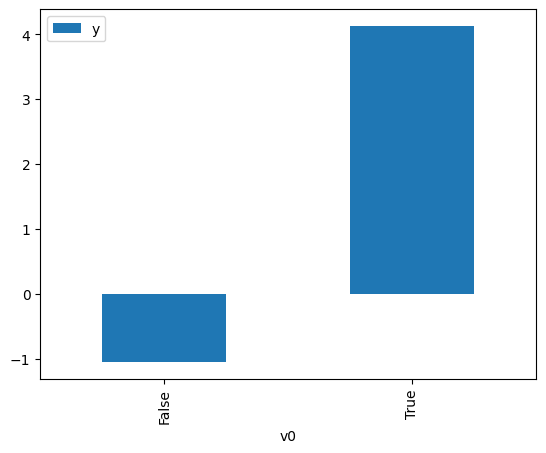

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

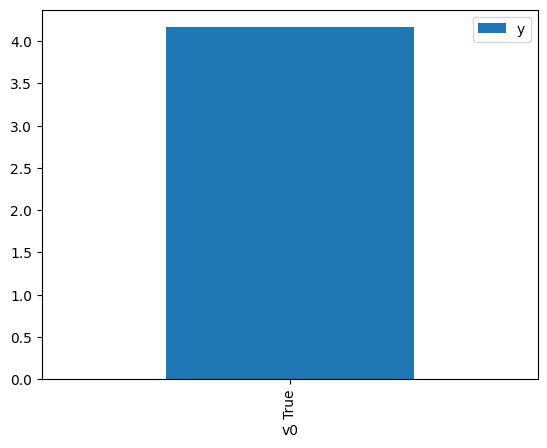

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.467549,False,-1.514155,0.570977,1.751383
1,-1.614698,False,-2.017867,0.740546,1.350354
2,-0.814400,False,-2.162784,0.626336,1.596587
3,-1.626279,False,-0.155668,0.742024,1.347666
4,0.215773,False,0.967871,0.457940,2.183692
...,...,...,...,...,...
995,-1.613703,False,-1.445127,0.740419,1.350587
996,-1.614698,False,-2.017867,0.740546,1.350354
997,0.658785,False,0.308634,0.386207,2.589288
998,-0.441217,False,-0.480947,0.566682,1.764658


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.007495,True,5.951584,0.507528,1.970336
1,-0.884924,True,4.141081,0.362753,2.756699
2,0.691429,True,6.173487,0.618927,1.615699
3,-1.110933,True,3.942882,0.328770,3.041643
4,-1.871376,True,1.902019,0.228020,4.385583
...,...,...,...,...,...
995,1.026728,True,6.510864,0.669960,1.492626
996,-2.689902,True,2.425737,0.146299,6.835316
997,-2.293895,True,1.269438,0.182344,5.484129
998,-0.666987,True,3.907619,0.396879,2.519659


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              4753.
Date:                Fri, 27 Jan 2023   Prob (F-statistic):                        0.00
Time:                        10:11:32   Log-Likelihood:                         -1400.7
No. Observations:                1000   AIC:                                      2805.
Df Residuals:                     998   BIC:                                      2815.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9971      0.024     41.035      0.000       0.949       1.045
x2             5.0670      0.053     95.944      0.000       4.963       5.171
==============================================================================
Omnibus:                        0.013   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.994   Jarque-Bera (JB):                0.047
Skew:                          -0.003   Prob(JB):                        0.977
Kurtosis:                       2.967   Cond. No.                         2.28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""